# Retrain RF on new data (experiment w/ weights)

In [98]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(tidyverse)


getwd()

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ purrr   0.3.4
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ data.table::between()    masks dplyr::between()
✖ randomForest::combine()  masks dplyr::combine()
✖ lubridate::date()        masks base::date()
✖ plotly::filter()         masks dplyr::filter(), stats::filter()
✖ data.table::first()      masks dplyr::first()
✖ lubridate::hour()        masks data.table::hour()
✖ lubridate::intersect()   masks base::intersect()
✖ lubridate::isoweek()     masks data.table::isoweek()
✖ dplyr::lag()             masks stats::lag()
✖ data.table::last()       masks dplyr::last()
✖ purrr::lift()            masks caret::lift()
✖ randomForest::margin()   masks ggplot2::margin()
✖ lubridate::mday()        masks data.table::mday()
✖ lubridate::minute()      masks data.table::minut

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_gcloudaccess"

In [156]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('functions_eval.R')


# Load data

In [ ]:
# system("gsutil cp gs://data_outputt/output/expiry_train_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_train_prepped_2")
expiry_train_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_train_prepped_1list")

# system("gsutil cp gs://data_outputt/output/expiry_test_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")
expiry_test_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_test_prepped_1list")


expiry_train_df <- rbindlist(expiry_train_prepped_2, fill=TRUE)
expiry_test_df <- rbindlist(expiry_test_prepped_2, fill=TRUE)

In [65]:
# system("gsutil cp gs://data_outputt/output/expiry_train_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_train_prepped_2")
expiry_train_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_train_prepped_2")

# system("gsutil cp gs://data_outputt/output/expiry_test_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")
expiry_test_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")


expiry_train_df <- rbindlist(expiry_train_prepped_2, fill=TRUE)
expiry_test_df <- rbindlist(expiry_test_prepped_2, fill=TRUE)

In [66]:
# was 139436639, 34859139... should be ~118.5M, 29.6M

dim(expiry_train_df)
dim(expiry_test_df)

[1] 1394366      39

[1] 348591     39

# subset to only include first renewal

In [145]:
# expiry_train_prepped_2_1 <- lapply(expiry_train_prepped_2, 
#                                       function(x)x[x[[1]]=='FirstTime'])
# expiry_test_prepped_2_1 <- lapply(expiry_test_prepped_2, 
#                                       function(x)x[x[[1]]=='FirstTime'])

expiry_test_prepped_2_1 <- expiry_test_prepped_2_1[sapply(expiry_test_prepped_2_1, function(x) dim(x)[1]) > 0]

In [149]:
# expiry_train_df_1 <- rbindlist(expiry_train_prepped_2_1, fill=TRUE)
expiry_test_df_1 <- rbindlist(expiry_test_prepped_2_1, fill=TRUE)

In [150]:
dim(expiry_train_df_1)
dim(expiry_test_df_1)

[1] 1188250      39

[1] 296797     39

# Retrain Ranger_03

## per the same definitions as in dtree_xl.ipynb, but added reg_arpt as a predictor

In [119]:
# expiry_train_df_1 <- expiry_train_df %>% filter(renewal_type == 'FirstTime')
expiry_train_df_sub <- subset(expiry_train_df_1, 
       select = c(renewal_status, tld, registrar, reseller, reseller_country, region, reg_period, 
                  sld_type, sld_length, day_domains, gibb_score, pattern_domain_count,reg_arpt) )
head(expiry_train_df_sub)

renewal_status,tld,registrar,reseller,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,l,7,1,6.77,1,15
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,ln,7,1,8.65,1,15
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,l,6,1,13.09,1,15
Not Renewd,fun,1&1 internet,1&1 internet,Germany,Non China,1,l,12,1,2.44,1,15
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,l,7,1,2.34,1,15
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,l,8,1,3.64,1,15


In [120]:
# expiry_test_df_1 <- expiry_test_df %>% filter(renewal_type == 'FirstTime')
expiry_test_df_sub <- subset(expiry_test_df_1, 
       select = c(renewal_status, tld, registrar, reseller, reseller_country, region, reg_period, 
                  sld_type, sld_length, day_domains, gibb_score, pattern_domain_count,reg_arpt) )
head(expiry_test_df_sub)

renewal_status,tld,registrar,reseller,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15
Not Renewd,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15
Not Renewd,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15
Renewed,fun,1api,1api,Germany,Non China,1,l,7,1,4.51,1,5
Not Renewd,fun,1api,1api,Germany,Non China,1,l,7,1,6.09,1,5


In [223]:
# model fitting: 952.151 sec elapsed (model fitting: 334.385 sec elapsed on 16 core)
# model saving: 163.762 sec elapsed


tic("model fitting")

ranger_03_expiry <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_train_df_sub, 
    importance = 'impurity', 
    num.trees       = 500,
#     class.weights = c(1,10000),
    probability = TRUE,
#     mtry            = 5,
#     min.node.size   = 10,
#     replace = FALSE,
#     sample.fraction = .725,
    seed            = 123
)

toc()

# tic("model saving")
# save(ranger_03_expiry, file="../../data/output/ranger_03_expiry")
# toc()

Growing trees.. Progress: 14%. Estimated remaining time: 3 minutes, 4 seconds.
Growing trees.. Progress: 31%. Estimated remaining time: 2 minutes, 20 seconds.
Growing trees.. Progress: 47%. Estimated remaining time: 1 minute, 45 seconds.
Growing trees.. Progress: 64%. Estimated remaining time: 1 minute, 9 seconds.
Growing trees.. Progress: 80%. Estimated remaining time: 39 seconds.
model fitting: 244.165 sec elapsed


## test ranger_03 on expiry_test

In [224]:

# model predict: 65.851 sec elapsed (18sec on 16 core)
# eval saving: 0.132 sec elapsed

tic("model predict")
ranger_predict_03_expiry <- predict(ranger_03_expiry, 
                          data = expiry_test_df_sub,
                          type="response")$predictions
toc()

# tic("eval saving")

ranger_predict_03_expiry <- as.data.frame(ranger_predict_03_expiry)$Renewed

# save(ranger_predict_03_expiry, 
#      file="../../data/output/ranger_predict_03_expiry")
# toc()


model predict: 16.979 sec elapsed


In [214]:
# load("../../data/output/ranger_predict_03_exptest")

In [225]:
ranger_03_pred_df_expiry = data.frame("actual" = expiry_test_df_sub$renewal_status,
          "predicted" = ranger_predict_03_expiry)

# lift df: 23.675 sec elapsed
# gains plot: 0.046 sec elapsed
# auc: 0.007 sec elapsed
tic("lift df")
lift_df_ranger_03_expiry <- chart_lift(pred_df = ranger_03_pred_df_expiry,
                        dep_var = "actual",
                        pred_var = "predicted")

toc()
tic("gains plot")
gains_plot_ranger_03_expiry <- plot_gains (lift_df_ranger_03_expiry) 

toc()
tic("auc")
auc_ranger_03_expiry <- calc_auc(lift_df_ranger_03_expiry)
toc()


# saveRDS(lift_df_ranger_03_expiry, file.path('../../data/output/',"lift_df_ranger_03_expiry"))


lift df: 1.164 sec elapsed
gains plot: 0.017 sec elapsed
auc: 0.005 sec elapsed


In [226]:
lift_df_ranger_03_expiry

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,11663,0.4294973,4.294973
0.2,16545,0.6092801,3.046400
0.3,20096,0.7400479,2.466826
0.4,22855,0.8416498,2.104124
0.5,24425,0.8994660,1.798932
0.6,25404,0.9355183,1.559197
0.7,26253,0.9667833,1.381119
0.8,26957,0.9927085,1.240886
0.9,27152,0.9998895,1.110988


[1] 0.7914841

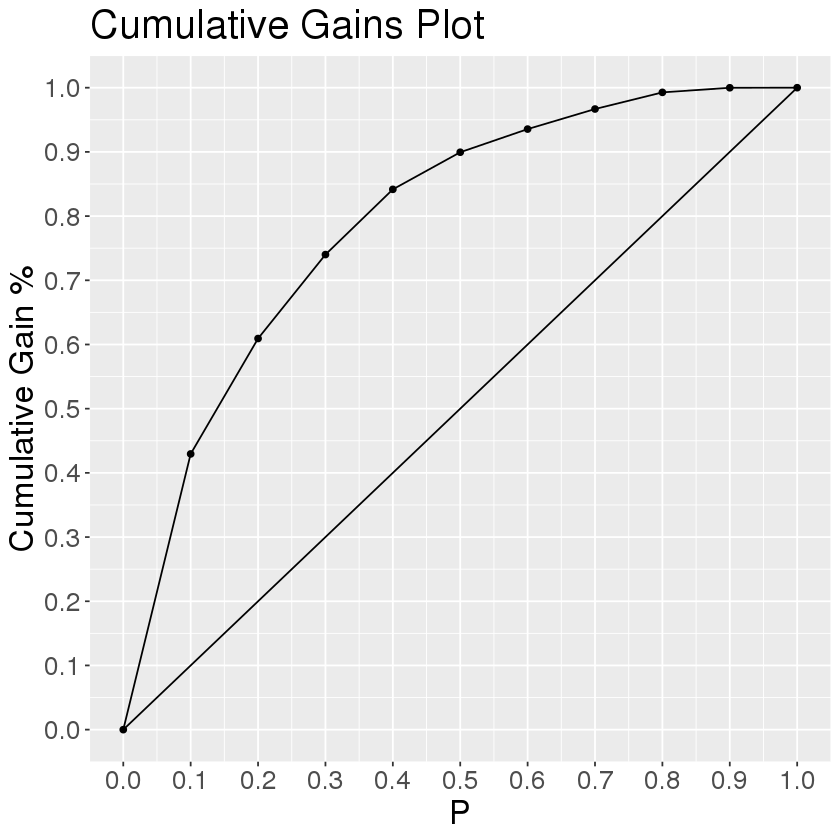

In [227]:
auc_ranger_03_expiry
gains_plot_ranger_03_expiry

In [169]:
system("gsutil cp /home/jupyter/local/Domains_202003/data/output/* gs://data_outputt/output/")

In [179]:
as.data.frame(sort(ranger_03_expiry$variable.importance,decreasing=TRUE))

,"sort(ranger_03_expiry$variable.importance, decreasing = TRUE)"
,<dbl>
gibb_score,59415.4044
day_domains,54127.3425
reg_arpt,50931.2397
sld_length,26282.1124
reseller,17327.6987
registrar,13639.6512
tld,9794.4114
reseller_country,9673.5338
pattern_domain_count,9407.5462


lift_df_ranger3

# how well does seg_glm perf when trained on this data?

## need to retrain model on expiry_train_prepped_2 (list of dfs)


In [131]:
# model fitting: 38.794 sec elapsed
# model saving: 48.062 sec elapsed

# model fitting: 48.917 sec elapsed on 16 core
# model saving: 42.567 sec elapsed

# tic("model fitting")
# first_renewal_model_expiry_train<-mass_build_model_first_renewal(expiry_train_prepped_2_1)
# toc()
# tic("model saving")
# saveRDS(first_renewal_model_expiry_train, "../../data/output/first_renewal_model_expiry_train")
# toc()


In [148]:
# model predict: 12.668 sec elapsed
# model predict: 11.492 sec elapsed on 16 core

# tic("model predict")
# seg_glm_expiry_exptest <- mass_predict_first_renewal(expiry_test_prepped_2_1, 
#                                                      first_renewal_model_expiry_train)
# toc()
# saveRDS(seg_glm_expiry_exptest,"../../data/output/seg_glm_expiry_exptest")


In [ ]:
# seg_glm_exptest <- readRDS("../../data/output/seg_glm_exptest")

In [151]:
seg_glm_expiry_exptest_pred_df = data.frame("actual" = expiry_test_df_1$renewal_status,
          "predicted" = seg_glm_expiry_exptest$first_renewal_prediction)

In [152]:
# lift df: 1.63 sec elapsed
# gains plot: 0.03 sec elapsed
# auc: 0.005 sec elapsed

tic("lift df")
lift_df_seg_glm_expiry_exptest <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df,
                        dep_var = "actual",
                        pred_var = "predicted")

toc()
tic("gains plot")
gains_plot_seg_glm_expiry_exptest <- plot_gains (lift_df_seg_glm_expiry_exptest) 

toc()
tic("auc")
auc_seg_glm_expiry_exptest<- calc_auc(lift_df_seg_glm_expiry_exptest)
toc()


saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/',"lift_df_seg_glm_expiry_exptest"))

lift df: 1.235 sec elapsed
gains plot: 0.025 sec elapsed
auc: 0.011 sec elapsed


In [153]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12855,0.4733935,4.733935
0.2,18703,0.6887498,3.443749
0.3,21934,0.8077334,2.692445
0.4,23996,0.8836678,2.209170
0.5,25222,0.9288161,1.857632
0.6,25942,0.9553305,1.592218
0.7,26322,0.9693242,1.384749
0.8,26584,0.9789726,1.223716
0.9,26643,0.9811453,1.090161


In [228]:
plot_multigains_03_summ4 <- plot_multigains(
    lift_df_list=list(
        rf_newd_ex = lift_df_ranger_03_expiry,
        seg_newd_ex = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        rf_newd_ex= calc_auc(lift_df_ranger_03_expiry),
        seg_newd_ex= calc_auc(lift_df_seg_glm_expiry_exptest)))
png(file = "../../data/output/plot_multigains_03_summ4.png",
    width = 500, height = 375)
plot(plot_multigains_03_summ4)
dev.off()

png 
  2

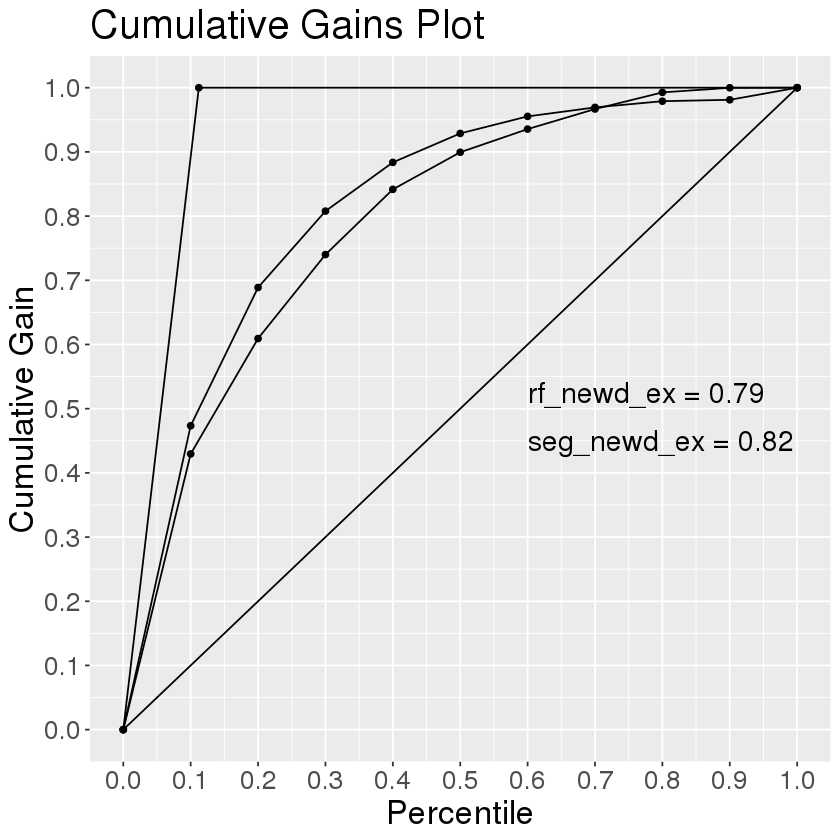

In [229]:
plot_multigains_03_summ4

In [230]:
lift_newdata_df <- cbind(lift_df_seg_glm_expiry_exptest[c("P","lift")],lift_df_ranger_03_expiry[c("lift")])
names(lift_newdata_df) <- c("pct","seg_glm","ranger_03")
lift_newdata_df


pct,seg_glm,ranger_03
<dbl>,<dbl>,<dbl>
0.1,4.733935,4.294973
0.2,3.443749,3.046400
0.3,2.692445,2.466826
0.4,2.209170,2.104124
0.5,1.857632,1.798932
0.6,1.592218,1.559197
0.7,1.384749,1.381119
0.8,1.223716,1.240886
0.9,1.090161,1.110988


# Confusion Matrices

In [231]:
CM_thresh_test <- function (actual, predicted, thresh){
    predicted <- as.factor(predicted>thresh)
    actual <- as.factor(actual=="Renewed")
    confusionMatrix(predicted,actual, positive="TRUE")
}

In [232]:
results5 <- CM_thresh_test(expiry_test_df_1$renewal_status,
                           seg_glm_expiry_exptest$first_renewal_prediction,
                           .5)
cm5 <- as.table(results5)
df5 <- as.matrix(results5, what = "classes")

results6 <- CM_thresh_test(expiry_test_df_1$renewal_status,
                           ranger_predict_03_expiry,
                           .5)
cm6 <- as.table(results6)
df6 <- as.matrix(results6, what = "classes")

In [233]:
perf_newdata_df <- cbind(as.data.frame(df5),as.data.frame(df6))
names(perf_newdata_df) <- c("seg_glm","ranger_03")
perf_newdata_df

,seg_glm,ranger_03
,<dbl>,<dbl>
Sensitivity,0.21552878,0.11946235
Specificity,0.98235344,0.98952685
Pos Pred Value,0.55016611,0.53460778
Neg Pred Value,0.92595505,0.91775502
Precision,0.55016611,0.53460778
Recall,0.21552878,0.11946235
F1,0.30972293,0.19528640
Prevalence,0.09102263,0.09149351
Detection Rate,0.01961800,0.01093003


In [234]:
cm5
cm6

          Reference
Prediction  FALSE   TRUE
     FALSE 263812  21096
     TRUE    4739   5796

          Reference
Prediction  FALSE   TRUE
     FALSE 266818  23911
     TRUE    2824   3244

# but ultimately, client fills NA's with data from "fallback tables", which would improve performance. asked client for script

In [67]:
# from /scripts/nedata_202005/explore

system("gsutil cp gs://data_input/npv_fallback_tables /home/jupyter/local/Domains_202003/data/npv_fallback_tables")

In [68]:
# npv_fallback_tables	
#   fallback tables where we dont have enough training 
#   data for a particular tld-registrar combination

npv_fallback_names <- load("/home/jupyter/local/Domains_202003/data/npv_fallback_tables")
npv_fallback_names

[1] "npv_fallback_first_final"        "npv_fallback_first_geo_arpt"    
 [3] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_tld_arpt"    
 [5] "npv_fallback_second_final"       "npv_fallback_second_geo"        
 [7] "npv_fallback_second_tld_geo"     "npv_fallback_third_final"       
 [9] "npv_fallback_third_geo"          "npv_fallback_third_tld_geo"

In [64]:
# [1] "npv_fallback_first_final"        "npv_fallback_first_geo_arpt"    
# [3] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_tld_arpt"    
# [5] "npv_fallback_second_final"       "npv_fallback_second_geo"        
# [7] "npv_fallback_second_tld_geo"     "npv_fallback_third_final"       
# [9] "npv_fallback_third_geo"          "npv_fallback_third_tld_geo" 

In [69]:
head(npv_fallback_first_final)

region,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
<chr>,<fct>,<int>,<int>,<dbl>,<chr>
China,"(-Inf,0]",35669,2139,0.060,"China(-Inf,0]"
China,"(0,1]",536645,11052,0.021,"China(0,1]"
China,"(1,3]",84869,12063,0.142,"China(1,3]"
China,"(3,5]",1356,340,0.251,"China(3,5]"
China,"(5,10]",177,36,0.203,"China(5,10]"
China,"(10,15]",427,122,0.286,"China(10,15]"


In [64]:
# Questions:
# not enough training means we also don't have "day_domains"?
# npv_fallback_first_final, _geo_arpt? renewal rate by country & buy price
# npv_fallback_first_final$reg_arpt_slab? reg_arpt: the price at which the domain is bought by the reseller 

# Using a decision tree means you don't need to retrain a model but we can do better than simply using a "fall back table" -- can we confirm this with historical data?

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '/home/jupyter/local/Domains_202003/data/npv_fallback_tables', probable reason 'No such file or directory'”


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


# Variable importance

In [38]:
# load("../../data/output/ranger_03_expiry") # new expiry data
load("../../data/ranger_03") # original data

In [47]:
as.data.frame(round(sort(ranger_03_expiry$variable.importance, decreasing=TRUE),0))

,"round(sort(ranger_03_expiry$variable.importance, decreasing = TRUE), 0)"
,<dbl>
reg_arpt,265675
day_domains,120616
gibb_score,99629
sld_length,43497
reseller,26344
registrar,21450
pattern_domain_count,19572
tld,17826
reseller_country,15428


In [46]:
as.data.frame(round(sort(ranger_03$variable.importance, decreasing=TRUE),0))

,"round(sort(ranger_03$variable.importance, decreasing = TRUE), 0)"
,<dbl>
day_domains,92600
gibb_score,86059
sld_length,28108
tld,25682
pattern_domain_count,15233
sld_type,12202
reg_period,10154
registrar,8546
reseller,8537


# Subset where renew_status is not missing

In [31]:
# na_train_df <- expiry_train_df  %>% 
#  summarise_all(~ sum(is.na(.)))  %>% 
#  t()  %>%  as.data.frame()
# na_train_df <- na_train_df[na_train_df$V1>0]
na_train_df

,V1
,<int>
renewal_type,0
renewed_count,0
expiry_date,0
domain_id,0
domain,0
creation_date,0
status,0
tld,0
registrar,0


# Explore renewal type var

In [32]:
expiry_train_df$renewal_type %>% table() %>% prop.table()

.
 FirstTime     Second Subsequent 
0.85217941 0.07805483 0.06976576 

In [34]:
expiry_test_df$renewal_type %>% table() %>% prop.table()

.
 FirstTime     Second Subsequent 
0.85141900 0.07859067 0.06999033 

# Explore autorenew_type as variable

In [35]:
expiry_train_df$autorenew_type %>% table() %>% prop.table()

.
             NULL presumed-realized          realized        unrealized 
     0.0002171294      0.0051060432      0.0811083406      0.9135684868 